In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# ============================
# ✅ Dataset Setup
# ============================
data_dir = os.path.join(os.getcwd(), 'combined_dataset')
img_height, img_width = 227, 227  # AlexNet uses 227x227 input
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

num_classes = train_generator.num_classes

# ============================
# ✅ AlexNet Architecture
# ============================
model = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(256, (5, 5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# ============================
# ✅ Compile and Train
# ============================
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Save best model by validation accuracy
checkpoint = ModelCheckpoint('alexnet_best_model.keras', monitor='val_accuracy',
                             save_best_only=True, mode='max', verbose=1)

epochs = 20
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    callbacks=[checkpoint]
)

# Final save (in case you want the last model too)
model.save('alexnet_final_model.keras')


Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


C:\Users\rmish\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\rmish\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5879 - loss: 1.7719

C:\Users\rmish\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.30120, saving model to alexnet_best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2215s 4s/step - accuracy: 0.5879 - loss: 1.7708 - val_accuracy: 0.3012 - val_loss: 2.8761
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5555 - loss: 0.9921
Epoch 2: val_accuracy improved from 0.30120 to 0.42540, saving model to alexnet_best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2198s 4s/step - accuracy: 0.5555 - loss: 0.9920 - val_accuracy: 0.4254 - val_loss: 1.5301
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7181 - loss: 0.6271
Epoch 3: val_accuracy did not improve from 0.42540
625/625 ━━━━━━━━━━━━━━━━━━━━ 2206s 4s/step - accuracy: 0.7181 - loss: 0.6271 - val_accuracy: 0.4196 - val_loss: 2.0786
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7678 - loss: 0.5681
Epoch 4: val_accuracy improved from 0.42540 to 0.47220, saving model to alexnet_best_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 2146s 3s/step - acc

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Dataset Setup ---
data_dir = os.path.join(os.getcwd(), 'combined_dataset')
img_height, img_width = 227, 227
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# --- Load the Trained Model ---
model = load_model("alexnet_final_model.keras")

# --- Unfreeze All Layers for Fine-Tuning ---
for layer in model.layers:
    layer.trainable = True

# --- Recompile with Lower Learning Rate ---
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# --- Callbacks ---
checkpoint = ModelCheckpoint("alexnet_finetuned_best.keras", monitor="val_accuracy", save_best_only=True)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, min_lr=1e-6)

# --- Fine-Tuning ---
history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


C:\Users\rmish\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1852s 3s/step - accuracy: 0.8966 - loss: 0.2731 - val_accuracy: 0.9224 - val_loss: 0.2074 - learning_rate: 1.0000e-05
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1836s 3s/step - accuracy: 0.9151 - loss: 0.2226 - val_accuracy: 0.9290 - val_loss: 0.1810 - learning_rate: 1.0000e-05
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1819s 3s/step - accuracy: 0.9288 - loss: 0.1903 - val_accuracy: 0.9376 - val_loss: 0.1618 - learning_rate: 1.0000e-05
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1827s 3s/step - accuracy: 0.9305 - loss: 0.1910 - val_accuracy: 0.9412 - val_loss: 0.1503 - learning_rate: 1.0000e-05
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1860s 3s/step - accuracy: 0.9362 - loss: 0.1706 - val_accuracy: 0.9444 - val_loss: 0.1436 - learning_rate: 1.0000e-05
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1828s 3s/step - accuracy: 0.9381 - loss: 0.1686 - val_accuracy: 0.9470 - val_loss: 0.1387 - learning_rate: 1.0000e-05
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 1841s 3s/ste

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# ---- Plot Accuracy & Loss ----
def plot_metrics(history, title_prefix=''):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = list(range(1, len(acc) + 1))  # Full integer labels

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ---- Plot Confusion Matrix ----
def plot_confusion_matrix(model, generator, title_prefix=''):
    predictions = model.predict(generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    class_labels = list(generator.class_indices.keys())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{title_prefix} Confusion Matrix')
    plt.tight_layout()
    plt.show()


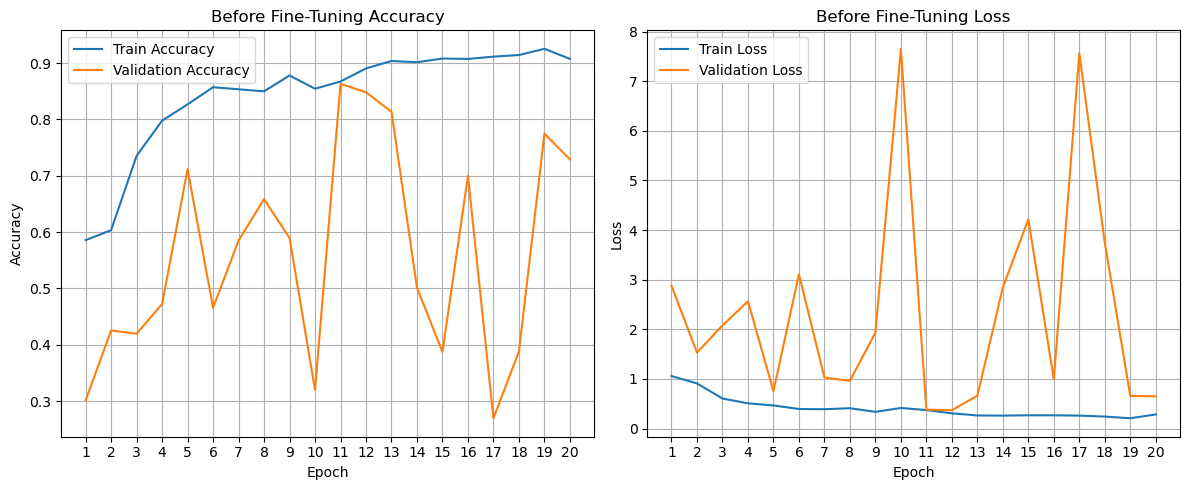

157/157 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step


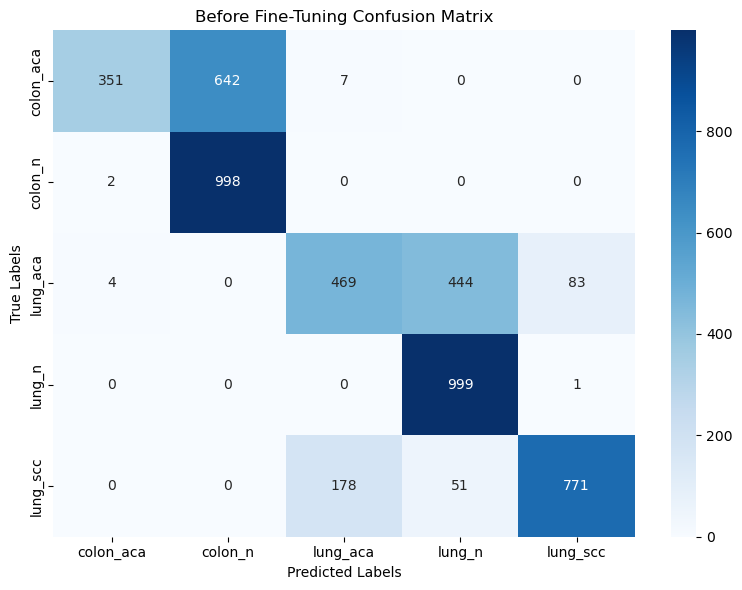

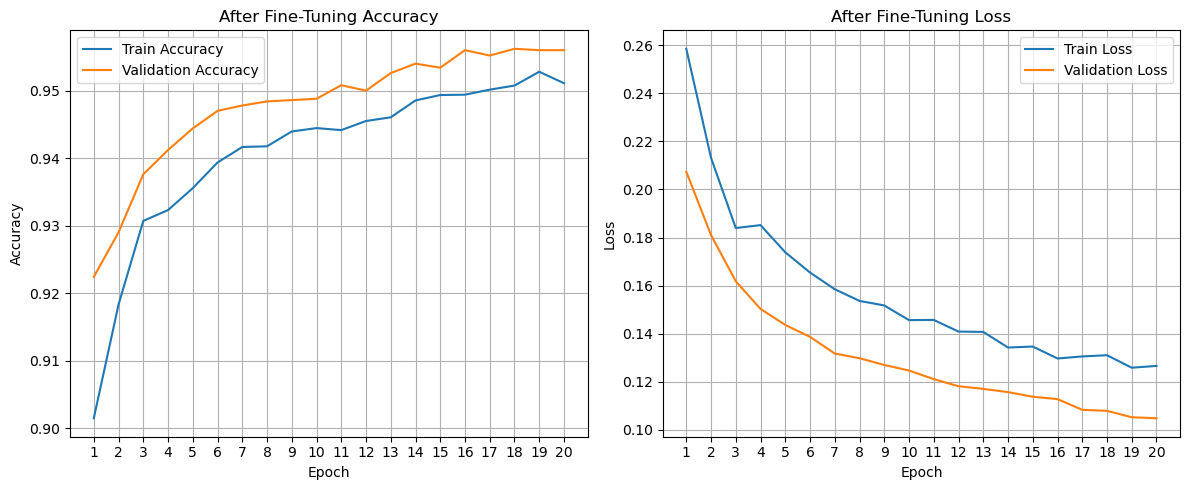

157/157 ━━━━━━━━━━━━━━━━━━━━ 119s 754ms/step


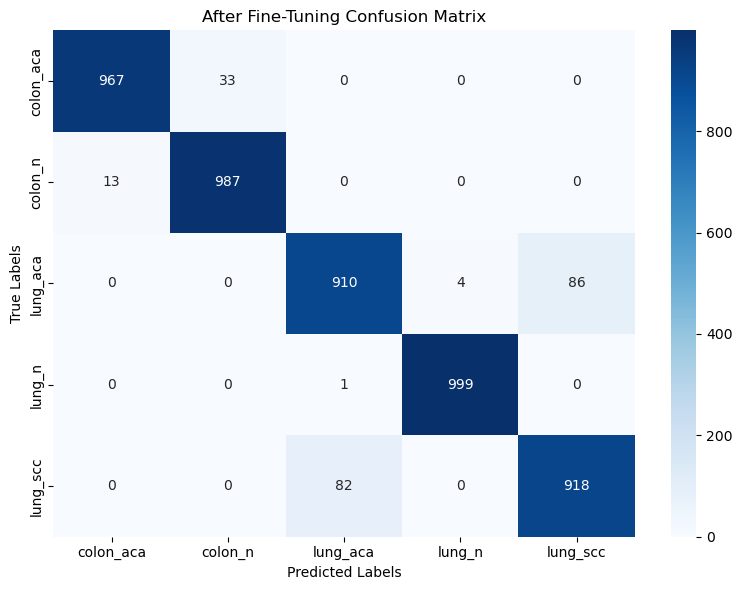

In [9]:
from tensorflow.keras.models import load_model

model_before_finetuning = load_model("alexnet_final_model.keras")
model_after_finetuning = load_model("alexnet_finetuned_best.keras")

# Plot BEFORE fine-tuning
plot_metrics(history, title_prefix='Before Fine-Tuning')
plot_confusion_matrix(model_before_finetuning, validation_generator, title_prefix='Before Fine-Tuning')

# Plot AFTER fine-tuning
plot_metrics(history_fine, title_prefix='After Fine-Tuning')
plot_confusion_matrix(model_after_finetuning, validation_generator, title_prefix='After Fine-Tuning')
